# The Flatland Symphony

This notebook demonstrates AcousticObservation, a Flatland observation builder inspired by acoustics. This contribution competes for the Community Price of the [NeurIPS2020 Flatland Challenge](https://www.aicrowd.com/challenges/neurips-2020-flatland-challenge/).

## Summary

> One of the main objectives of the Flatland challenge is to find a suitable observation to solve the problems.

Ready for something completely different? As stated above, this observation builder is inspired by acoustics. Every object in the rail network emits characteristic “sounds” which propagate through the grid, recording information about their path.

Sounds eventually converge to an agent’s “ear”. Ears buffer sounds and encode them into state observations suitably formatted to be processed by conventional RL policies.

This observation builder has been carefully handcrafted with the following goals in mind:
* Try to improve on existing observations. Specifically, be at the same time more precise and more concise.
* Adapt to both small and large environments
* Be customizable, cleanly coded and well-documented. Make life easy for interested developers.

That said, this observation builder is experimental and still a work in progress. You'll find more information about incoming improvements at the end of the document. 

**Now it's up to you. Learn about the symphony's background and concepts below or jump right into the [code](#start).**

<br/>

## Introduction
One of the main challenges in the current edition of Flatland is the variable number of features present in each environment. During evaluation, agents are faced with increasingly larger maps, which they initially share with just a handful of other agents. Soon, there are hundreds and even thousands of other agents trying to get to their destinations at the same time.

Deep RL approaches are based on conventional neural networks with a fixed number of input neurons. How to encode such a huge variability efficiently? This is a huge challenge. I spent many hours thinking about different possibilities. Ideally, with enough time, I would have liked to build a custom graph transformer with some form of attention to deal with graphs of any size. I got this idea from the last competition that I participated in, where some of the top teams used [BERT](https://www.kaggle.com/c/champs-scalar-coupling/discussion/106572) and [transformers](https://www.kaggle.com/c/champs-scalar-coupling/discussion/106575) to predict molecular properties. I even found [very promising papers on Graph Neural Networks (GNNs) applied to RL](https://github.com/thunlp/GNNPapers#reinforcement-learning). After a week of reading, it was clear to me that this approach was beyond what I could accomplish before the contest’s end. There had to be some other way.

Looking for inspiration in nature, insects and animals, it occurred to me that smells or maybe sounds might be the answer. After all, sounds are relatively compact waveforms that carry lots of information in the spectral domain. After listening for only a couple of seconds of a particular sound, you are immediately able to distinguish individual components, like voices, animals, vehicles and so on. Could such an encoding be useful in our setting? As it soon became evident, actual physical sounds are in no way suited to navigate a rail network. But unlike the physical world, this is Flatland, and the laws of physics are defined by us. Welcome to the Flatland Symphony.

## Elements of the Flatland Symphony

### Sounds
The Flatland Symphony is all about sounds. Agents and stations on Flatland emit sounds which propagate through the network. Sounds carry the fingerprint of the emitter and further encode information about all cells they visit. When a sound reaches its target, the listener can tell what generated that sound on the network and precisely how it travelled through it.
In a way, sounds are the opposite of a tree observation: They work their way from the origin to the observer, but capture only the essential path information and ignore other branches. Buffering sound objects is the abstract equivalent of adding up spectral components and then converting the resulting waveform to the time domain (i.e. simultaneously recognizing several voices in a single recording).

### Ears
Trains with ears? Yeah, why not – this is a symphony! Every agent in the Flatland Symphony listens to sounds with an “ear”. An ear is the agent’s sensory organ, the means to understand and navigate their environment. Ears are basically buffers that can apply arbitrary transformations on the sounds they hear and encode them for further processing. The observation builder includes a simple ear which returns observations as a fixed-length numpy array, suitable as input for traditional ANNs. Developers can use the provided ear interface to define their own ears and thus their own sound processing pipelines.

### Graphs
The observation builder encodes the grid as a NetworkX graph. The graph representation of a rail network is all but straightforward. Every cell in the grid actually encapsulates four different states, depending on the agent’s heading. I originally intended to use a directed graph, similar to the [ones discussed last year](https://youtu.be/rGzXsOC7qXg?t=1718). However, to be really useful for propagation, the representation should be a directed multigraph with different types of edges – Too fancy. So I chose a simpler yet powerful representation: Rail networks in the Flatland Symphony are encoded as *un*directed graphs where cells are nodes and connections are edges. The interesting part is that cells’ transition matrices are stored as node attributes. An agent can move from a node to another if they are connected and if the transition matrix of its current node allows that particular transition.

### Headings and directions
The Flatland environment has four cardinal directions: North, East, South and West. Agents can move in four relative directions: Straight, Left, Right and Back (at a dead end, if they can turn). To keep these concepts apart, I use the word “heading” when referring to a cardinal direction, and “direction” when referring to a direction relative to the agent.

### Sound propagation
Sounds can move between any two connected nodes even if agents are bound to the transition matrix's dictates. Sounds just encode the move differently as they would a “legal” move. In other words, sounds pass through and encode unusable switches (unusable for agents). Actually, when a sound reaches a cell with several exits, it splits and creates as many copies of itself as exits are available. These copies propagate down those paths. 

Sounds do not propagate forever. Each sound is created with a certain reach, a number which defines how often it can turn before extinguishing. Additionally, to prevent endless loops, sounds extinguish immediately if they reach a node-heading tuple that they have visited before. A node-heading tuple is the combination of node position and sound’s heading. Why the node alone does not suffice will be explained further below.

### Thoughts on Graph Neural Networks (GNNs)
I spent a great deal of time reading about GNNs, since they seem to be the natural choice for this kind of problem. Conceptually, sound propagation is not far away from message passing – it literally is a message being passed through nodes. However, there a couple of fundamental differences:
* Only selected nodes can emit messages
* Unlike GNNs, sounds are not aggregated by nodes. On the contrary, sounds capture node information while propagating
* Only selected nodes can aggregate messages (those with agents)

<a id="start"></a>

# Time for some code!

In [1]:
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt

from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_generators import sparse_rail_generator
from flatland.envs.schedule_generators import sparse_schedule_generator
from flatland.utils.rendertools import RenderTool

from acoustic_observation import TransitionMatrix, Sound, Ear, FixedLengthEar, AcousticObservation

In [2]:
%matplotlib inline

## Create a sample environment

In [3]:
SIZE = 20

rail_generator=sparse_rail_generator(
    max_num_cities = 3,
    grid_mode = False,
    max_rails_between_cities = 4,
    max_rails_in_city = 2, 
    seed = 1000
)

env = RailEnv(
    width=SIZE, height=SIZE,
    rail_generator=rail_generator,
    schedule_generator=sparse_schedule_generator(),
    number_of_agents=3,
)

env.reset();

In [4]:
# Render the grid
env_renderer = RenderTool(env)
img = env_renderer.render_env(show=False, frames=True, show_observations=False, return_image=True, show_rowcols=True)

## Initialize the observation

In [5]:
# Define the observation parameters. We'll look deeper into these parameters later.
sound_params = {"reach": 5, "capacity": 5}
ear_params = {"ear_capacity": 20, "sound_capacity": 5}

# Instantiate an AcousticObservation object, assign it to the previously created env and initialize/reset the observation.
observation = AcousticObservation(sound_parameters=sound_params, ear_parameters=ear_params)
observation.set_env(env)
observation.reset()
rail_graph = observation.graph

## Visualize the environment and the graph
(Static images in case the next cell does not render properly)

<img src="media/env_rendered.png" alt="drawing" width="500"/>
<img src="media/env_graph.png" alt="drawing" width="750"/>

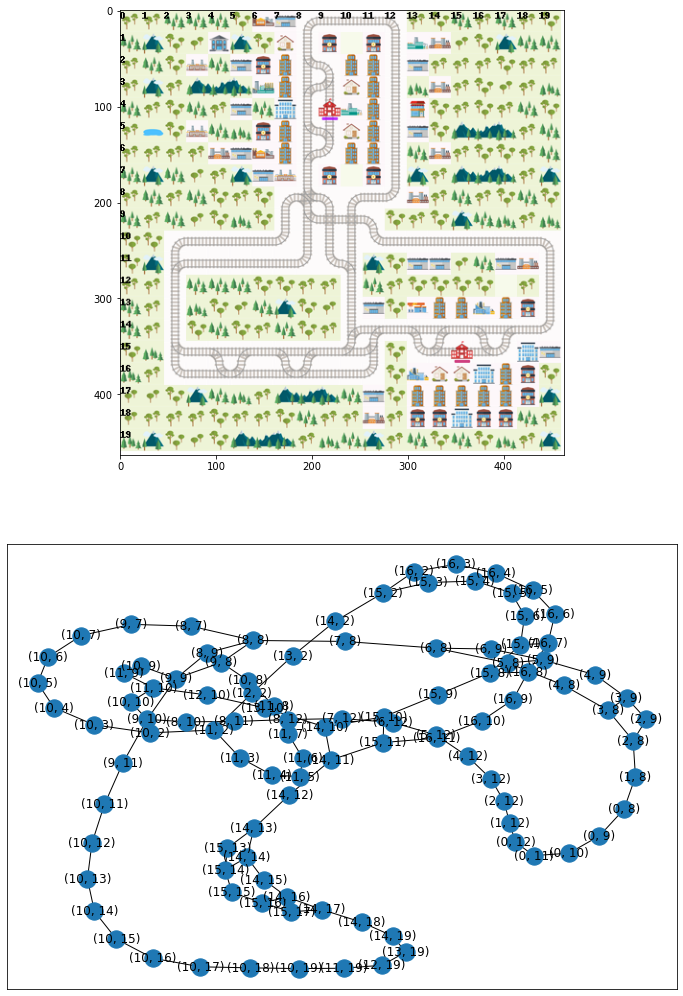

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(12,18))
axs[0].imshow(img)
nx.draw_networkx(rail_graph, ax = axs[1])

## Let's inspect a single node

In [7]:
# In the acoustic observation's graph, nodes are tuples (row, column) representing a cell on the grid.
# NetworkX nodes can have attributes (they are stored in a dict), and our nodes have two of them.
# Let's inspect the top left cell of the network, located at (0, 8).
rail_graph.nodes[0,8].keys()

dict_keys(['transitions', 'sounds'])

## The transition matrix
Let's inspect the transitions first

In [8]:
node = rail_graph.nodes[0,8]
print(node['transitions'])

TransitionMatrix(transition_uint16=16386, transitions=array([[0, 1, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 1, 0]]), exits=array([False,  True,  True, False]), exits_tuple=(1, 2))


In [9]:
# The TransitionMatrix is the first class defined in acoustic_observation.py
# It is basically just the matrix with some additional useful methods and pre-computed values
TransitionMatrix??

Init signature: TransitionMatrix(transition_uint16: int) -> None
Source:        
class TransitionMatrix:
    """transition_map is a uint16 coded as NN NE NS .... SE SS SW
    The matrix looks like:
               Exits (Axis=0)
     Headings   N E S W
     (Axis=1) N 0 1 0 0
              E 0 1 0 0
              S 0 0 0 0
              W 0 0 1 1
             """
    transition_uint16: int
    transitions: np.ndarray = field(init=False)
    exits: np.ndarray = field(init=False)
    exits_tuple: Tuple = field(init=False)

    def __post_init__(self):
        assert self.transition_uint16 > 0, "TransitionMatrix instantiated on an empty cell"
        self.transitions = np.array([int(x) for x in bin(self.transition_uint16)[2:].zfill(16)]).reshape(4, 4)
        self.exits = self.transitions.any(axis=0)
        self.exits_tuple = tuple(exit_ for exit_, exists in enumerate(self.exits) if exists)  # I love this

    def can_transition(self, old_heading: int, new_heading: int) -> int:
        re

In [10]:
# The matrix itself is stored in .transitions
node['transitions'].transitions

array([[0, 1, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 1, 0]])

In [11]:
# .exits shows which transitions are possible (independent of the agent's heading).
node['transitions'].exits

array([False,  True,  True, False])

In [12]:
# .exits_tuple is the same information in tuple form. These attributes will make our lives much easier later.
node['transitions'].exits_tuple

(1, 2)

## Sounds

In [13]:
# There are numerous sounds travelling along the rails in any Flatland environment.
# To speed up computation, sounds emitted by the stations are pre-computed when observation.reset() is called.
# They are stored into the node's field sounds. There can be are quite a few.
len(node['sounds'])

317

In [14]:
# Let's see what are the maximum and minimum number of sounds per node.
number_of_sounds = [len(sounds) for sounds in nx.get_node_attributes(rail_graph, 'sounds').values()]
min(number_of_sounds)

180

In [15]:
max(number_of_sounds)

758

In [16]:
# This is of course too many. Most of these sounds have followed very convoluted paths to arrive at the node and are likely uninteresting.
# I'm working on a number of improvements to make the number more manageable, listed at the end of the notebook.

## Let's inspect a single sound

In [17]:
sample_sound = node['sounds'][0]

In [18]:
type(sample_sound)

acoustic_observation.Sound

In [19]:
vars(sample_sound)

{'position': (0, 8),
 'heading': 0,
 'frequency': -1,
 'reach': 5,
 'capacity': 5,
 'doppler': 0,
 'malfunction': 0,
 '_visited_nodes': {((0, 8), 0),
  ((1, 8), 0),
  ((2, 8), 3),
  ((2, 9), 0),
  ((3, 9), 0),
  ((4, 9), 0)},
 '_turns': deque([1]),
 '_distances': deque([3]),
 'origin': ((4, 9), 0),
 '_distance_travelled': 2,
 'total_distance_travelled': 5,
 '_n_turns': 1}

In [20]:
# The sound's public attributes are defined in the class docstring
Sound?

Init signature:
Sound(
    position: Tuple,
    heading: int,
    frequency: float,
    reach: int,
    capacity: int,
    doppler: int = 0,
    malfunction: int = 0,
) -> None
Docstring:     
An observable unit of information, emitted in a certain heading and able to propagate across the rail.

Attributes:
    position (Tuple): The sound's position on the network.
    heading (int): The sound's heading.
    frequency (float): The sound's frequency.
    reach (int): The number of times this sound can turn before extinguishing.
    capacity (int): The size of the _turns and _distances deques.
    doppler (int): Indicates whether the sound is moving in the same or contrary direction as the emitter.
    malfunction (int): Information on the emitter's malfunction, if existing.
    origin (Tuple): The emitter's position.
    valid_journey (bool): True if the sound didn't turn illegally.
    total_distance_travelled (int): The number of nodes that this sound has visited.
File:           ~/py

## Sound frequency
Most of these attributes should be self-explanatory, but frequency deserves a special mention.

Think of frequency as the unique ID of an emitter. Sounds with different frequencies are generated by different entities.

Station frequencies are assigned at random when observation.reset() is called. The first station receives the frequency 0, the next one the frequency -1 and so on.

Agent frequencies are related to their target station frequencies. Suppose there are $n$ agents targeting a station with frequency $f_{station}$.  These agents will be ordered randomly (from 0 to n-1) and assigned a frequency according to the formula $f_{agent} = -f_{station} + (i+1)/(n+2)$

This ensures that all agents targeting a station with frequency -f can be easily identified because they have frequencies in the range (f, f+1).

## Encoding a sound's path: _turns and _distances
We want sounds to precisely encode their path through the network. We also want this encoding to be as compact as possible. 

Consider the following actions that a sound could take at any node: `S` for going straight, `L` for turning left, `R` for turning right. Now assume that, after emission, some particular sound moved straight 3 nodes, then turned right and continued for another five nodes. We could encode the path as `3R5`. If now the sound turned left and continued for ten more nodes, we could encode its path as `3R5L10`. This is as compact as it gets.

In reality, a sound can do more than that. A sound can turn ilegally, so we will define the following mapping:
* -2: Turn left illegally
* -1: Turn left legally
* 0: Continue straight
* 1: Turn right legally
* 2: Turn right ilegally

By definition, sounds can't turn back. Why would they need to? 

We will now divide our path encoding into two vectors, `_turns` and `_distances`. `_turns` is a vector of the actions taken by the sound, as just defined. `_distances` indicates how many straight steps the sound makes before taking the respective action. Behind the scenes, both are implemented as a `deque`.

In other words:
```
_turns     = [1, 1, -1]
_distances = [3, 2,  8]
```
is equivalent to `3R2R8L` in our previous notation.

We now only need to make sure that the ear knows from which _relative direction_ it is hearing the sound. If the agent is at a crossing, it must distinguish between sounds coming from the front and from either side. We encode this relative direction as the last element in `_turns`. The last element of `_distances` just indicates the number of steps from the last turn to the agent. To simplify things, agents can't hear sounds coming from their backs. 

Since the last element of both vectors has a special meaning, the deques are popped in a last-in, first-out fashion. In this way, the last value will always have the same position in the neural network's encoding. More on that when we talk about ears.

## _visited_nodes
You might have noticed that _visited_nodes contains node-heading tuples instead of only tuples. Why? Consider the following graph:

<img src="media/sample_graph.png" alt="drawing" width=350/>

Assume that a station emits a sound at 0 which can continue straight throught nodes 1, 3 and 2 until it reaches its agent at 4. Further assume that there is no suitable switch at 1 to allow a 4 -> 1 -> 0 transition. If the sound only stores the visited nodes, all the agent will know is that there is an illegal transition in front of him - He will not "see" the loop! However, if the sound stores node-heading pairs, the agent will know that there is an illegal transition in front of him _and_ a straight line leading right to its target. The sound travelling straight is simpler, so it will be picked over the other ones (as proposed in the improvements at the end of this document).

## Ears

In [21]:
# We've reached the last piece of the puzzle, the ears!
# Ears are stored as a dict and can be accessed by handles.
observation.ears

{0: FixedLengthEar(agent=EnvAgent(initial_position=(15, 6), initial_direction=1, direction=1, target=(15, 15), moving=False, speed_data={'position_fraction': 0.0, 'speed': 1.0, 'transition_action_on_cellexit': 0.0}, malfunction_data={'malfunction': 0, 'malfunction_rate': 0.0, 'next_malfunction': 0, 'nr_malfunctions': 0, 'moving_before_malfunction': False}, handle=0, status=<RailAgentStatus.READY_TO_DEPART: 0>, position=None, old_direction=None, old_position=None), ear_capacity=20, sound_capacity=5, agent_frequency=0.25, cell=None, buffer=[]),
 1: FixedLengthEar(agent=EnvAgent(initial_position=(4, 8), initial_direction=2, direction=2, target=(15, 15), moving=False, speed_data={'position_fraction': 0.0, 'speed': 1.0, 'transition_action_on_cellexit': 0.0}, malfunction_data={'malfunction': 0, 'malfunction_rate': 0.0, 'next_malfunction': 0, 'nr_malfunctions': 0, 'moving_before_malfunction': False}, handle=1, status=<RailAgentStatus.READY_TO_DEPART: 0>, position=None, old_direction=None, old

In [22]:
# acoustic_observation provides a simple Ear interface that you can build upon.
Ear??

Init signature: Ear(agent: flatland.envs.agent_utils.EnvAgent) -> None
Source:        
class Ear:
    """An interface for an agent's 'ear'."""
    agent: EnvAgent

    def listen(self, sounds: Union[Sound, List[Sound]]) -> None:
        """Called by AcousticObservation whenever one or more sounds reach this ear."""
        raise NotImplementedError

    def encode(self):
        """Returns an encoding of the sounds that this ear has been listening to."""
        raise NotImplementedError
File:           ~/python/acoustic_observation/acoustic_observation.py
Type:           type
Subclasses:     FixedLengthEar


In [23]:
# By default, AcousticObservation uses instances of the subclass FixedLengthEar
ear = observation.ears[0]
type(ear)

acoustic_observation.FixedLengthEar

In [24]:
# FixedLengthEar contains a reference to the corresponding agent and a couple other attributes.
vars(ear)

{'agent': EnvAgent(initial_position=(15, 6), initial_direction=1, direction=1, target=(15, 15), moving=False, speed_data={'position_fraction': 0.0, 'speed': 1.0, 'transition_action_on_cellexit': 0.0}, malfunction_data={'malfunction': 0, 'malfunction_rate': 0.0, 'next_malfunction': 0, 'nr_malfunctions': 0, 'moving_before_malfunction': False}, handle=0, status=<RailAgentStatus.READY_TO_DEPART: 0>, position=None, old_direction=None, old_position=None),
 'ear_capacity': 20,
 'sound_capacity': 5,
 'agent_frequency': 0.25,
 'buffer': []}

In [25]:
# The most interesting one is the buffer. It is a list where all sounds that reach this ear will be appended.
# The magic happens in the .encode() function - this returns a fixed-length numpy array that can be passed to the actual neural network.
ear.encode??

Signature: ear.encode() -> numpy.ndarray
Source:   
    def encode(self) -> np.ndarray:
        """Sample length elements at random from buffer."""
        # Sample the rest at random if needed
        if len(self.buffer) > self.ear_capacity:
            sounds = random.sample(self.buffer, self.ear_capacity)
            # Always keep the sound with the shortest valid distance to the target
            first = True
            for sound in self.buffer:
                if sound.valid_journey & (sound.frequency == -math.floor(self.agent_frequency)):
                    if first:
                        total_distance_travelled = sound.total_distance_travelled
                        shortest_valid_sound = sound
                        first = False
                        continue
                    if sound.total_distance_travelled < total_distance_travelled:
                        shortest_valid_sound = sound
            if first:
                warnings.warn(f"Agent {self.agent.hand

In [26]:
# A well-designed encoding is essential to the whole Flatland Symphony, since it returns the actual observations. 
observation.get_many??

Signature: observation.get_many(handles: Union[List[int], NoneType] = None)
Docstring:
Called whenever an observation has to be computed for the `env` environment, for each agent with handle
in the `handles` list.

Parameters
----------
handles : list of handles, optional
    List with the handles of the agents for which to compute the observation vector.

Returns
-------
function
    A dictionary of observation structures, specific to the corresponding environment, with handles from
    `handles` as keys.
Source:   
    def get_many(self, handles: Optional[List[int]] = None):
        # Update the position of all agents present in the grid
        self.agent_at_position = {agent.position: agent.handle
                                  for agent in self.env.agents if agent.position is not None}

        # Update ear's transition matrix & listen to station sounds (pre-computed in self.reset())
        for position, handle in self.agent_at_position.items():
            self.ears[handle].c

## Thoughs on encoding
In FixedLengthEar, if there are more sounds in the buffer than can be encoded, it samples a subset at random, keeping the sound with the shortest path to the agent’s target. Due to the large number of sounds, this can be inefficient (Though I haven't tried yet!) I will improve this soon: If the buffer is too large for the fixed-length encoding, the ear should not sample randomly, but distribute capacity as evenly as possible among different emitters, always preferring sounds with simpler paths. The rationale is that we’re generally not interested in sounds that follow extremely convoluted paths to reach a given destination.


## Improvements
I’m currently working on the following improvements:
* Implement an upper limit on the number of sounds per emitter that can be saved to a node. Keep the sounds with the simplest paths.
* Improve FixedLengthEar’s encoding function as explained above.
* Play nice with Flatland’s starter’s kit. Adapt multi_agent_acoustic_training.py to use AcousticObservation instead of the tree observation.

Further possible improvements (to bre researched):
* Set an upper bound on the number of illegal turns that a sound can make (maybe 1 or 2)
* Investigate the best values for the sound’s reach. Is a very low number (2 or 3) enough/preferable?
* Investigate using different sound reach values for trains and stations.
* Investigate whether the simplest sound from the agent’s target should always reach the agent.
* You know what would be awesome? To process all sounds with a transformer and have it select relevant sounds with an attention mechanism. Then again, if you can do that, you could try to encode the whole network directly. Drop me a message if you decide to explore this possibility!

## Acknowledgements
* I'd like to thank my employer, [qdive GmbH](https://www.qdive.io/), for granting me a couple of business days to participate in the Flatland challenge.
* I'd like to mention [Jonas Wälter's master thesis](https://eprints.hsr.ch/855/1/Masterarbeit_Waelter_Jonas.pdf), which was invaluable in understanding the Flatland environment.

## Licensing & further work
All code contained in this submission is published under a MIT license. I hope future contestants find this observation useful and can build upon it.

</br></br>

This was a lot of fun!